In [3]:
import numpy as np
import pandas as pd
from numpy import array

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
import sys
sys.path.append('/content/drive/MyDrive')

In [6]:
def buildLaggedFeatures(s,lag=2,dropna=True):
    #Builds a new DataFrame to facilitate regressing over all possible lagged features'''
    if type(s) is pd.DataFrame:
        new_dict={}
        for l in range(lag,0,-1):
            #new_dict[col_name]=s[col_name]
            # create lagged Series
            for col_name in s:
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        for col_name in s:
            new_dict[col_name]=s[col_name]
        res=pd.DataFrame(new_dict,index=s.index)
        #print(res.head())

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

In [7]:
def create_data(scaler2,data,lag):
    #o_data = read_csv('NLIC_stock.csv', header=0)
    #data['Date'] = pd.to_datetime(o_data['Date'])
    #mask = (data['Date'] > '2011-11-11') & (data['Date'] <= '2018-12-30')
    #t_data=data.loc[mask]
    t_data= data.drop(columns=['Symbol'])
    t_data.set_index(['Date'], inplace=True)
    t_data=t_data.drop(columns=['Open','High','Vol','Low'])
    t_data['Close'] = scaler2.transform((t_data['Close'].to_numpy()).reshape(-1,1))
    #print(t_data.head())
    res=buildLaggedFeatures(t_data,lag,dropna=True)
    #print(res.head())
    res=res.drop(columns=['Close'])
    
    return res  

In [8]:
def create_yvalues(scaler2,df,lead):
    dataY = []
    df['Close'] = scaler2.transform((df['Close'].to_numpy()).reshape(-1,1))
    #print(df.head())
    for i in range(len(df)-lead):
        dataY.append(df[i:(i+lead)])
    return np.array(dataY)

In [9]:
data = pd.read_csv('/content/drive/MyDrive/EBL_stock.csv', header=0)
data['Date'] = pd.to_datetime(data['Date'])
mask = (data['Date'] > '2011-11-11') & (data['Date'] <= '2019-02-28')
t_data=data.loc[mask]
#print(t_data.head())
scaler2=MinMaxScaler()
x_sample = [60, 3000]
scaler2.fit(np.array(x_sample)[:, np.newaxis])
lag=12
prediction_days=20
trainX= create_data(scaler2,t_data,lag)
tY= data[lag:len(trainX)+prediction_days+lag]
t_y=pd.DataFrame(tY['Close'])
#print(t_y.head())
#print(len(trainX),len(trainY))
trainY=create_yvalues(scaler2,t_y,prediction_days)
trainY=trainY.transpose(2,0,1).reshape(-1,trainY.shape[1])
print(trainY)
trainY=pd.DataFrame(trainY)
#print(trainX.head())


print(trainY.head())
print(trainY.shape)

#print(trainX.head(),trainY.head(5))
#print(trainX.shape)



[[0.21530612 0.21326531 0.21258503 ... 0.20646259 0.21054422 0.20748299]
 [0.21326531 0.21258503 0.20748299 ... 0.21054422 0.20748299 0.21088435]
 [0.21258503 0.20748299 0.21156463 ... 0.20748299 0.21088435 0.21564626]
 ...
 [0.15306122 0.15204082 0.15204082 ... 0.16768707 0.16836735 0.16870748]
 [0.15204082 0.15204082 0.15306122 ... 0.16836735 0.16870748 0.16938776]
 [0.15204082 0.15306122 0.15272109 ... 0.16870748 0.16938776 0.17040816]]
         0         1         2   ...        17        18        19
0  0.215306  0.213265  0.212585  ...  0.206463  0.210544  0.207483
1  0.213265  0.212585  0.207483  ...  0.210544  0.207483  0.210884
2  0.212585  0.207483  0.211565  ...  0.207483  0.210884  0.215646
3  0.207483  0.211565  0.214286  ...  0.210884  0.215646  0.210884
4  0.211565  0.214286  0.210884  ...  0.215646  0.210884  0.213605

[5 rows x 20 columns]
(1646, 20)


In [10]:

train_x = trainX.values
# split into train and test sets

#print(Q.tail())
#q=scaler2.fit_transform(Q.values)

#print(c)
train_y=trainY.values
train_x=np.array(train_x)
train_y=np.array(train_y)

#print(c[1512-12:])
#print(train_y[1512-12:])

train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
train_y =np.reshape(train_y, (train_y.shape[0], train_y.shape[1], 1))
print(len(train_x),len(train_y),train_x.shape,train_y.shape)

1646 1646 (1646, 12, 1) (1646, 20, 1)


In [11]:
import tensorflow as tf
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from tensorflow.keras import initializers
initializer = tf.keras.initializers.GlorotNormal()
batch_size = 32
opt=Adam(
    learning_rate=0.00007,
    beta_1=0.7,
    beta_2=0.99,
    epsilon=1e-08,
    amsgrad=True,
    )

model = Sequential()
model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(lag,1)))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(prediction_days))
model.add(LSTM(512, activation='tanh',kernel_initializer=initializer, return_sequences=True))
model.add(LSTM(512, activation='tanh',kernel_initializer=initializer,  return_sequences=True))  
model.add(LSTM(256, activation='tanh',kernel_initializer=initializer,  return_sequences=True)) 
model.add(TimeDistributed(Dense(200, activation='relu')))
model.add(TimeDistributed(Dense(200, activation='relu')))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer=opt)

In [12]:
%%time
history=model.fit(train_x, train_y, epochs=100, batch_size=batch_size, shuffle=False)

Epoch 1/100
52/52 [==============================] - 18s 48ms/step - loss: 0.1074
Epoch 2/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0500
Epoch 3/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0397
Epoch 4/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0353
Epoch 5/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0318
Epoch 6/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0316
Epoch 7/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0324
Epoch 8/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0308
Epoch 9/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0289
Epoch 10/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0302
Epoch 11/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0272
Epoch 12/100
52/52 [==============================] - 2s 43ms/step - loss: 0.0254
Epoch 13/100
52/52 [====

In [13]:
#share price cant differ by +-10% each day 
def adjust_initial_bias(x,y):
  if (y[0]> 1.1*x):
    y[0]=1.1*x
  if (y[0]< 0.9*x):
    y[0]=0.9*x
  for i in range(1,len(y)):
    if (y[i]>1.1*y[i-1]):
      y[i]= 1.1*y[i-1]
    if (y[i]<0.9*y[i-1]):
      y[i]= 0.9*y[i-1]
  return y


In [14]:
def get_prediction(y,scaler2,test_data):
  Out=model.predict(y,verbose=0)
  #print(Out)
  Out=Out.reshape(1,-1)
  
  Out=Out.reshape(-1,1)
  Out=  scaler2.inverse_transform(Out)
  z=test_data['Close'].values
  #z[-1]
  Out=adjust_initial_bias(z[-1],Out)
  output_7=pd.DataFrame(Out)  
  return output_7


In [19]:
predict_after="2019-9-15"
Y=data.copy
test_data=data.loc[data['Date'] < predict_after].tail(lag+1)
print(test_data)
output_test_data=data.loc[data['Date'] >= predict_after].head(prediction_days)
output_test_data.set_index(['Date'],inplace=True)
output_test_close=output_test_data['Close']
X=create_data(scaler2,test_data,lag)
adj=X.copy()
X=X.values
#X=scaler1.transform(X.values)
X = np.reshape(X, (1,X.shape[1], X.shape[0]))
model_output=get_prediction(X,scaler2,test_data)
model_output.set_index(output_test_close.index,inplace=True)
model_output.rename(columns={0:'Close'},inplace=True)
output_test_close=pd.DataFrame(output_test_close)
print(model_output)
print(output_test_close)



     Symbol       Date  Open  High  Low  Close     Vol
1779    EBL 2019-08-27   655   660  648    650   7,271
1780    EBL 2019-08-28   660   660  644    644   2,847
1781    EBL 2019-08-29   645   647  641    644   7,637
1782    EBL 2019-09-01   645   645  630    630   9,999
1783    EBL 2019-09-02   630   630  608    613   8,783
1784    EBL 2019-09-03   611   626  601    626  10,507
1785    EBL 2019-09-04   638   638  624    626  12,249
1786    EBL 2019-09-05   623   626  622    622   6,963
1787    EBL 2019-09-08   620   620  608    610   5,239
1788    EBL 2019-09-09   610   610  590    602  19,909
1789    EBL 2019-09-10   601   610  594    598   5,414
1790    EBL 2019-09-11   593   600  588    590   8,523
1791    EBL 2019-09-12   601   601  580    580  10,357
                 Close
Date                  
2019-09-15  606.650574
2019-09-16  654.221680
2019-09-17  650.967468
2019-09-18  586.880310
2019-09-19  557.791992
2019-09-22  543.901917
2019-09-23  544.338806
2019-09-24  550.428284


In [20]:
def error(X,Y):
    Close_error= ((X['Close'] - Y['Close']) ** 2).mean() ** .5
    print("Close_error =",Close_error)

In [21]:
error(output_test_close,model_output)

Close_error = 35.856478723760354


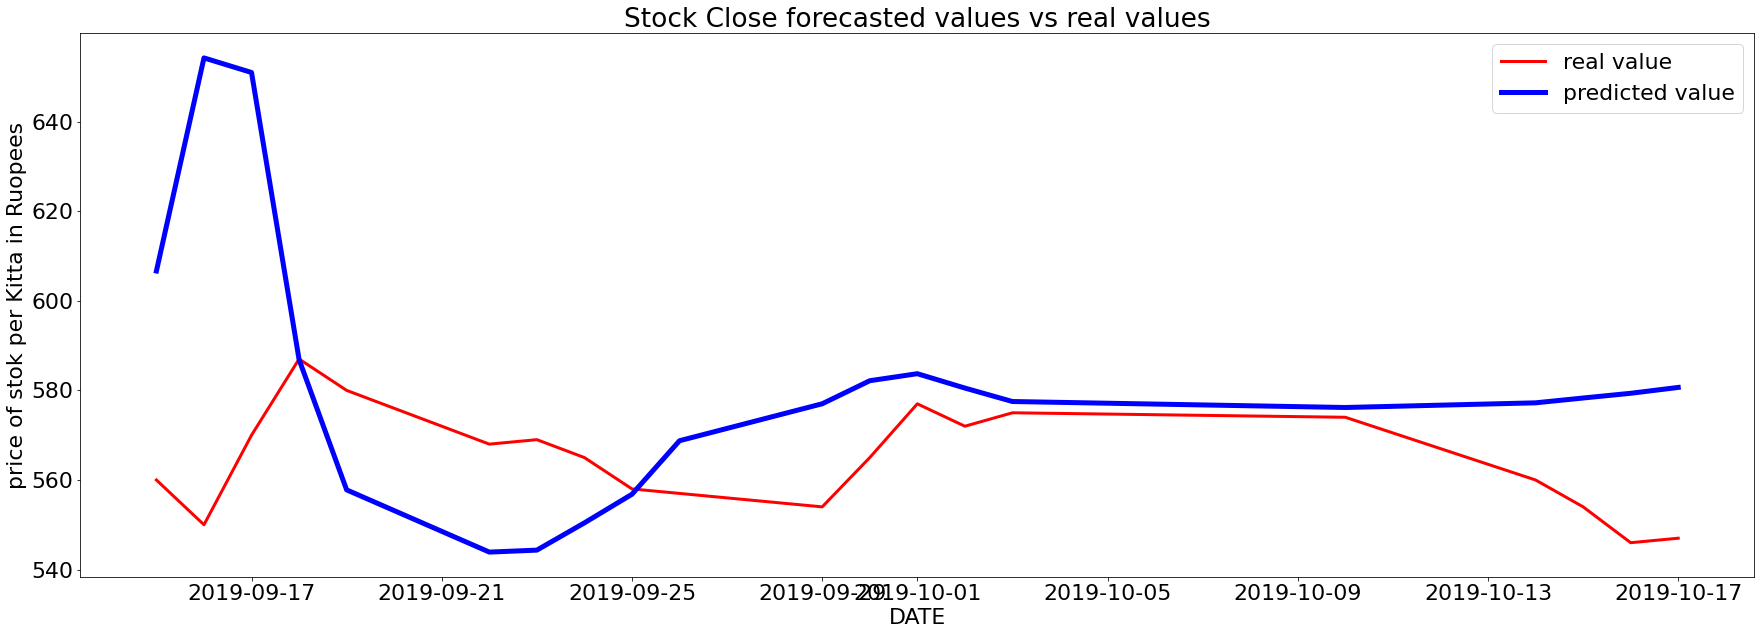

In [22]:
real= output_test_close
predicted= model_output
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.plot(real, color = 'red',linewidth=3, label = 'real value')
plt.plot(predicted, color = 'blue', linewidth=5,label = 'predicted value')
plt.title('Stock Close forecasted values vs real values')
plt.xlabel('DATE')
plt.ylabel('price of stok per Kitta in Ruopees')
plt.legend()
plt.show()